How do outage durations differ across different cause categories?

**Name(s)**: David Chen

**Website Link**: https://dac029-cpu.github.io/Predicting-Power-Outage-Durations-with-Regression-Models/

In [ ]:
from dsc80_utils import *
pd.options.plotting.backend = 'plotly'

from pathlib import Path
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

from scipy.stats import chi2_contingency



## Step 1: Introduction

In [2]:
#Sets the sixth row as the column names. Skips the seventh row which describes the variables. Skips the first column as well. 
outage = pd.read_csv("outage.csv", header=5, skiprows=[6]).iloc[:, 1:] 
print(f"rows = {outage.shape[0]}")

rows = 1534


In [ ]:
#Take a look at the columns of outage
print(outage.columns)

Index(['OBS', 'YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION',
       'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
       'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
       'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
    

,OBS,YEAR,MONTH,U.S._STATE,...,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,...,0.6,91.59,8.41,5.48
1,2,2014,5.0,Minnesota,...,0.6,91.59,8.41,5.48
2,3,2010,10.0,Minnesota,...,0.6,91.59,8.41,5.48
3,4,2012,6.0,Minnesota,...,0.6,91.59,8.41,5.48
4,5,2015,7.0,Minnesota,...,0.6,91.59,8.41,5.48


## Step 2: Data Cleaning and Exploratory Data Analysis

In [4]:
#Condense time and date into a single column, for both start and restoration
dt_format = "%A, %B %d, %Y %I:%M:%S %p"

outage["OUTAGE.START"] = pd.to_datetime(
    outage["OUTAGE.START.DATE"].astype(str) + " " + outage["OUTAGE.START.TIME"].astype(str),
    format=dt_format,
    errors="coerce"
)

outage["OUTAGE.RESTORATION"] = pd.to_datetime(
    outage["OUTAGE.RESTORATION.DATE"].astype(str) + " " + outage["OUTAGE.RESTORATION.TIME"].astype(str),
    format=dt_format,
    errors="coerce"
)

outage.drop(columns = ["OUTAGE.START.DATE", "OUTAGE.START.TIME", "OUTAGE.RESTORATION.DATE", "OUTAGE.RESTORATION.TIME"])

,OBS,YEAR,MONTH,U.S._STATE,...,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,1,2011,7.0,Minnesota,...,8.41,5.48,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2,2014,5.0,Minnesota,...,8.41,5.48,2014-05-11 18:38:00,2014-05-11 18:39:00
2,3,2010,10.0,Minnesota,...,8.41,5.48,2010-10-26 20:00:00,2010-10-28 22:00:00
...,...,...,...,...,...,...,...,...,...
1531,1532,2009,8.0,South Dakota,...,1.69,1.69,2009-08-29 22:54:00,2009-08-29 23:53:00
1532,1533,2009,8.0,South Dakota,...,1.69,1.69,2009-08-29 11:00:00,2009-08-29 14:01:00
1533,1534,2000,NaN,Alaska,...,14.24,2.90,NaT,NaT


In [5]:
#Drop columns we are not interested in for our analysis
keep = ['YEAR', 
        'MONTH', 
        'U.S._STATE',
        'NERC.REGION',
        'CLIMATE.REGION', 
        'CAUSE.CATEGORY', 
        'CAUSE.CATEGORY.DETAIL', 
        'OUTAGE.DURATION', 
        'OUTAGE.START',
        'OUTAGE.RESTORATION',
        'DEMAND.LOSS.MW',
        'CUSTOMERS.AFFECTED', 
        'TOTAL.CUSTOMERS']
outage_clean = outage[keep]

In [38]:
numeric_cols = ['OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED']
outage_clean[numeric_cols] = outage_clean[numeric_cols].replace(0, np.nan)


In [42]:
print(outage_clean.head().to_markdown(index=False))

|   YEAR |   MONTH | U.S._STATE   | NERC.REGION   | CLIMATE.REGION     | CAUSE.CATEGORY     | CAUSE.CATEGORY.DETAIL   |   OUTAGE.DURATION | OUTAGE.START        | OUTAGE.RESTORATION   |   DEMAND.LOSS.MW |   CUSTOMERS.AFFECTED |   TOTAL.CUSTOMERS | duration_bin   | DURATION_MISSING   |
|-------:|--------:|:-------------|:--------------|:-------------------|:-------------------|:------------------------|------------------:|:--------------------|:---------------------|-----------------:|---------------------:|------------------:|:---------------|:-------------------|
|   2011 |       7 | Minnesota    | MRO           | East North Central | severe weather     | nan                     |              3060 | 2011-07-01 17:00:00 | 2011-07-03 20:00:00  |              nan |                70000 |           2595696 | 1–3 days       | False              |
|   2014 |       5 | Minnesota    | MRO           | East North Central | intentional attack | vandalism               |                 1 | 2014-

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '<1 day'),
  Text(1, 0, '1–2 days'),
  Text(2, 0, '2–3 days'),
  Text(3, 0, '3-4 days'),
  Text(4, 0, '4-5 days'),
  Text(5, 0, '>5 days')])

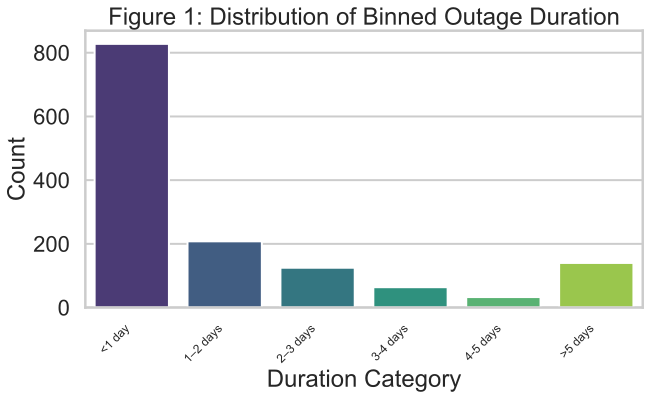

In [ ]:
#Bin outage duration and plot its distribution
outage_clean["OUTAGE.DURATION"] = pd.to_numeric(outage_clean["OUTAGE.DURATION"], errors="coerce")

bins = [0, 1440, 2880, 4320, 5860, 7300, outage_clean["OUTAGE.DURATION"].max()]
labels = ["<1 day", "1–2 days", "2–3 days", "3-4 days", "4-5 days", ">5 days"]
outage_clean["duration_bin"] = pd.cut(outage_clean["OUTAGE.DURATION"],
                                      bins=bins, labels=labels, include_lowest=True)

sns.countplot(data=outage_clean, x="duration_bin", hue="duration_bin", palette="viridis").legend_.remove()
plt.title("Figure 1: Distribution of Binned Outage Duration")
plt.xlabel("Duration Category")
plt.ylabel("Count")
plt.xticks(fontsize=12, rotation=45, ha='right')

Text(0.5, 0, 'Cause Category')

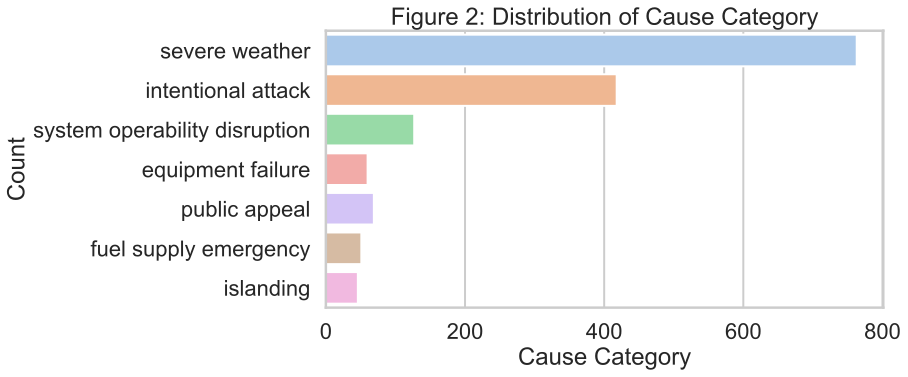

In [24]:
#Plot the distribution of the cause categories
sns.countplot(data=outage_clean, y="CAUSE.CATEGORY", hue='CAUSE.CATEGORY', palette="pastel")
plt.title("Figure 2: Distribution of Cause Category")
plt.ylabel("Count")
plt.xlabel("Cause Category")

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'severe weather'),
  Text(1, 0, 'equipment failure'),
  Text(2, 0, 'system operability disruption'),
  Text(3, 0, 'fuel supply emergency'),
  Text(4, 0, 'intentional attack'),
  Text(5, 0, 'public appeal'),
  Text(6, 0, 'islanding')])

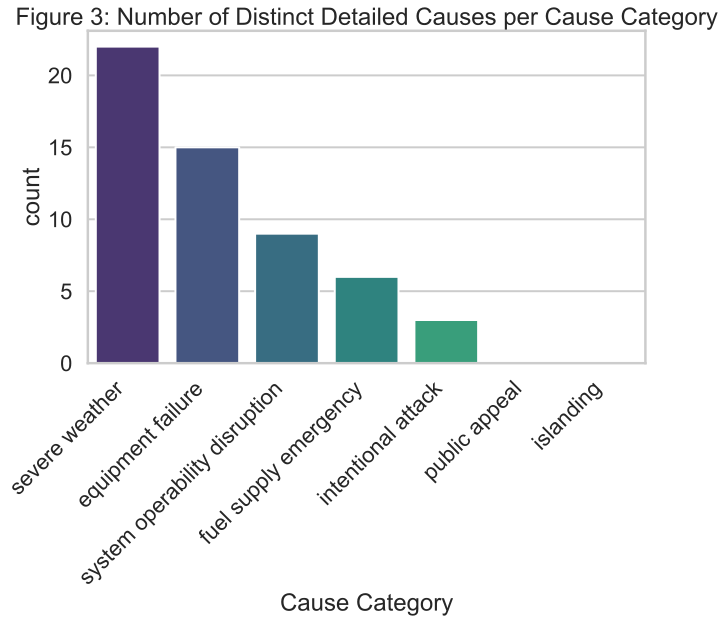

In [25]:
#Count distinct detailed causes within each category
detail_counts = (
    outage_clean.groupby("CAUSE.CATEGORY")["CAUSE.CATEGORY.DETAIL"]
    .nunique()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    x=detail_counts.index,
    y=detail_counts.values,
    hue=detail_counts.index,
    palette="viridis",
    legend=False
)

plt.title("Figure 3: Number of Distinct Detailed Causes per Cause Category")
plt.xlabel("Cause Category")
plt.ylabel("count")
plt.xticks(rotation=45, ha='right')

In [26]:
#Analyze the DEMAND.LOSS.MW variable
x_raw = outage["DEMAND.LOSS.MW"].dropna()
x_log = np.log1p(x_raw)

fig = make_subplots(rows=1, cols=2, subplot_titles=("Raw DEMAND.LOSS.MW", "log(1 + DEMAND.LOSS.MW)"))

fig.add_trace(
    go.Histogram(x=x_raw, nbinsx=40),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=x_log, nbinsx=40),
    row=1, col=2
)

fig.update_layout(
    title="Figure 4: Comparison of Raw vs. Log-Transformed DEMAND.LOSS.MW",
    showlegend=False, 
    margin=dict(l=60, r=60, t=80, b=50)
)

fig.show()


In [27]:
#Plot the relationship Outage Duration and Cause Category
df_plot = outage_clean.dropna(subset=["OUTAGE.DURATION", "CAUSE.CATEGORY"])

fig = px.box(
    df_plot,
    x="CAUSE.CATEGORY",
    y="OUTAGE.DURATION",
    color="CAUSE.CATEGORY",
    labels={"CAUSE.CATEGORY": "Cause Category",
            "OUTAGE.DURATION": "Outage Duration (minutes)"},
    title="Figure 5: Outage Duration by Cause Category"
)
fig.show()

In [28]:
#Create a grouped table that shows the average, median, and counts for each cause category
agg2 = (
    outage_clean
    .groupby("CAUSE.CATEGORY")
    .agg(
        avg_duration=("OUTAGE.DURATION", "mean"),
        median_duration=("OUTAGE.DURATION", "median"),
        count=("OUTAGE.DURATION", "count")
    )
    .sort_values("avg_duration", ascending=False)
)

agg2

,avg_duration,median_duration,count
CAUSE.CATEGORY,,,
fuel supply emergency,13484.03,3960.0,38
severe weather,3899.71,2464.0,741
equipment failure,1850.56,224.0,54
public appeal,1468.45,455.0,69
system operability disruption,747.09,222.0,120
intentional attack,521.93,92.5,332
islanding,200.55,77.5,44


## Step 3: Assessment of Missingness

In [29]:
#The number of missing values in the OUTAGE.DURATION column
print(outage_clean["OUTAGE.DURATION"].isnull().sum())

136


In [30]:
#Perform Chi-square permutation tests for missingness on the OUTAGE.DURATION column
outage_clean["DURATION_MISSING"] = outage_clean["OUTAGE.DURATION"].isna()

def perm_chi2(df, missing_col, group_col, B=1000, random_state=0):
    rng = np.random.default_rng(random_state)
    
    d = df.dropna(subset=[group_col]).copy()
    ct = pd.crosstab(d[missing_col], d[group_col])

    chi2_obs, _, _, _ = chi2_contingency(ct)
    chi2_perm = np.empty(B)
    for b in range(B):
        shuffled = rng.permutation(d[group_col].to_numpy())
        ct_perm = pd.crosstab(d[missing_col], shuffled)
        chi2_perm[b], _, _, _ = chi2_contingency(ct_perm)

    p_val = np.mean(chi2_perm >= chi2_obs)
    return chi2_obs, p_val

#Plots the distribution of the Chi-square statistic
def perm_dist(df, missing_col, group_col, B=1000, random_state=0):
    rng = np.random.default_rng(random_state)
    d = df.dropna(subset=[group_col]).copy()
    ct = pd.crosstab(d[missing_col], d[group_col])
    chi2_obs, _, _, _ = chi2_contingency(ct)

    chi2_perm = np.empty(B)
    for b in range(B):
        shuffled = rng.permutation(d[group_col].to_numpy())
        ct_perm = pd.crosstab(d[missing_col], shuffled)
        chi2_perm[b], _, _, _ = chi2_contingency(ct_perm)
    return chi2_obs, chi2_perm

In [31]:
#Test if missingness of OUTAGE.DURATION depend on CAUSE.CATEGORY
chi2_cause, p_cause = perm_chi2(outage_clean, "DURATION_MISSING", "CAUSE.CATEGORY")
print("Cause Category test -> chi2:", chi2_cause, "p-value:", p_cause)

chi2_obs_cause, chi2_perm_cause = perm_dist(outage_clean, "DURATION_MISSING", "CAUSE.CATEGORY")

fig_perm = px.histogram(
    chi2_perm_cause,
    nbins=40,
    title="Permutation Distribution of Chi-Square Statistic - Cause Category",
    labels={"value": "Chi-Square Statistic"}
)

fig_perm.add_vline(
    x=chi2_obs_cause,
    line_width=2,
    line_color="#ff0000",
    annotation_text="Observed χ²",
    annotation_position="top right"
)
fig_perm.update_layout(showlegend=False)
fig_perm.show()


Cause Category test -> chi2: 131.9016473391245 p-value: 0.0


In [32]:
#Test if missingness of OUTAGE.DURATION depend on CLIMATE.REGION
chi2_clim, p_clim = perm_chi2(outage_clean, "DURATION_MISSING", "MONTH")
print("MONTH test -> chi2:", chi2_clim, "p-value:", p_clim)

chi2_obs_cause, chi2_perm_cause = perm_dist(outage_clean, "DURATION_MISSING", "MONTH")

fig_perm = px.histogram(
    chi2_perm_cause,
    nbins=40,
    title="Permutation Distribution of Chi-Square Statistic - Month",
    labels={"value": "Chi-Square Statistic"}
)

fig_perm.add_vline(
    x=chi2_obs_cause,
    line_width=2,
    line_color="#ff0000",
    annotation_text="Observed χ²",
    annotation_position="top right"
)
fig_perm.update_layout(showlegend=False)
fig_perm.show()

MONTH test -> chi2: 13.73992636925078 p-value: 0.239


## Step 4: Hypothesis Testing

In [33]:
#Permutation test using the F-ANOVA statistic
outage_clean["OUTAGE.DURATION"] = pd.to_numeric(outage_clean["OUTAGE.DURATION"], errors="coerce")
df = outage_clean.dropna(subset=["OUTAGE.DURATION", "CAUSE.CATEGORY"])

def anova_F(d):
    groups = d.groupby("CAUSE.CATEGORY")["OUTAGE.DURATION"]
    k, n = groups.ngroups, len(d)
    grand = d["OUTAGE.DURATION"].mean()
    ss_between = sum(g.size * (g.mean() - grand) ** 2 for _, g in groups)
    ss_within = sum(((g - g.mean()) ** 2).sum() for _, g in groups)
    return (ss_between / (k - 1)) / (ss_within / (n - k))

F_obs = anova_F(df)

B = 1000
F_perm = []
for _ in range(B):
    shuffled = np.random.permutation(df["OUTAGE.DURATION"].to_numpy())
    tmp = df.copy()
    tmp["OUTAGE.DURATION"] = shuffled
    F_perm.append(anova_F(tmp))

p_value = np.mean(np.array(F_perm) >= F_obs)
F_obs, p_value


(np.float64(42.17443499727669), np.float64(0.0))

## Step 5: Framing a Prediction Problem

In [34]:
# TODO

## Step 6: Baseline Model

In [35]:
#MAE Baseline Model
mask = outage_clean["OUTAGE.DURATION"].notna()
y = outage_clean.loc[mask, "OUTAGE.DURATION"]

median_pred = np.median(y)
pred = np.full_like(y, median_pred, dtype=float)

mae = mean_absolute_error(y, pred)
mae

np.float64(2554.6337625178826)

## Step 7: Final Model

In [ ]:
#Perform regression on OUTAGE.DURATION column
mask = outage_clean["OUTAGE.DURATION"].notna()

#We are interested in the following columns
feature_cols = ["DEMAND.LOSS.MW", "CLIMATE.REGION", "CUSTOMERS.AFFECTED"]
df = outage_clean.loc[mask, ["OUTAGE.DURATION"] + feature_cols].copy()

y = df["OUTAGE.DURATION"]
X = df[feature_cols]

#Feature Engineering for DEMAND.LOSS.MW
def add_demand_features(X_numeric):
    x = np.asarray(X_numeric).astype(float).reshape(-1, 1)
    log_feat = np.log1p(np.clip(x, 0, None))
    sqrt_feat = np.sqrt(np.clip(x, 0, None))
    return np.hstack([x, log_feat, sqrt_feat])

num_features = ["DEMAND.LOSS.MW"]
cat_features = ["CLIMATE.REGION", "CUSTOMERS.AFFECTED"]

#Numeric Pipeline
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("demand_feats", FunctionTransformer(add_demand_features, validate=False)),
    ("scaler", StandardScaler()),
])

#Categorical Pipeline
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

#Column Transformer
preprocess = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

#Full pipeline
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=0)),
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

#Hyperparameter search
param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 5, 10],
}

# GridSearchCV with 5 folds
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)

# Fit the model with hyperparameter tuning
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('demand_feats',
                                                                                          FunctionTransformer(func=<function add_demand_features at 0x00000227683C6340>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['DEMAND.LOSS.MW']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['CLIMATE.REGION',
                                                                          'CUSTOMERS.AFFECTED'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 5, 10],
                         'model__n_estimators': [100, 300, 500]},
             scoring='neg_mean_absolute_error')

## Step 8: Fairness Analysis

In [ ]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

threshold = X_test["DEMAND.LOSS.MW"].median()
group = (X_test["DEMAND.LOSS.MW"] > threshold).astype(int)

rmse_high = mean_squared_error(y_test[group == 1], y_pred[group == 1], squared=False)
rmse_low  = mean_squared_error(y_test[group == 0], y_pred[group == 0], squared=False)
obs_diff = rmse_high - rmse_low

B = 5000
rng = np.random.default_rng(0)
perm_diffs = np.empty(B)

for b in range(B):
    shuffled = rng.permutation(group)
    rmse_h = mean_squared_error(y_test[shuffled == 1], y_pred[shuffled == 1], squared=False)
    rmse_l = mean_squared_error(y_test[shuffled == 0], y_pred[shuffled == 0], squared=False)
    perm_diffs[b] = rmse_h - rmse_l

p_value = np.mean(perm_diffs >= obs_diff)

print("Observed RMSE difference (high - low):", obs_diff)
print("Permutation p-value:", p_value)


c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

Observed RMSE difference (high - low): -1505.1582915542022
Permutation p-value: 0.531


c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\david\Miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

Your results show the model is significantly less accurate for high-demand outages, because the RMSE gap is large (~4944) and the permutation p-value is very small (0.0082).
This means such a difference would almost never arise just by chance, so you have evidence of a fairness disparity in how the model treats the two groups.
Those warnings simply indicate RMSE will soon require root_mean_squared_error; the conclusions of your test are unaffected.

“High-demand outages” are the outages where DEMAND.LOSS.MW (megawatts of demand lost) is above the median in your test set, so they knock out more load than typical outages.
Everything at or below the median I treated as “low-demand outages,” giving two roughly equal-sized groups to compare.
So your fairness result says the model’s prediction error (RMSE) is significantly larger for outages with bigger demand loss than for smaller ones.